In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations 

import matplotlib.pyplot as plt
import json
import networkx as nx 
import argparse
import config
import os 

import re



# 0, Utility


### Generate edges 

In [30]:
num_of_agents = 4
drop_prob = 0.05
agent_ids = np.arange(num_of_agents)
edges = list(combinations(agent_ids,2))

edges_list = []
edges_for_dropout = []
for item in edges:
    edges_list.append( list(item) )
    edges_for_dropout.append( list(item + (drop_prob,)) )

print(edges_list)
print(edges_for_dropout)

[[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
[[0, 1, 0.05], [0, 2, 0.05], [0, 3, 0.05], [1, 2, 0.05], [1, 3, 0.05], [2, 3, 0.05]]


Get camera intrinsic 

In [5]:
cam_depthai = np.array([    [3.00123340e+03, 0.00000000e+00, 1.94568164e+03],                            
                            [0.00000000e+00, 3.00060986e+03, 1.12127881e+03],                              
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]  ])

factor = 1/6
print(f'  fx: {cam_depthai[0][0]*factor} \n fy: {cam_depthai[1][1]*factor} \n cx: {cam_depthai[0,2]*factor} \n cy: {cam_depthai[1,2]*factor}')

  fx: 500.20556666666664 
 fy: 500.1016433333333 
 cx: 324.2802733333333 
 cy: 186.87980166666665


### Table processing

In [3]:

# Data from the table (replace with actual values)
data = {
    "DSGD": {
        "Artifacts": [6.38, 16.39, 14.59, 100],
        "Holes": [2.70, 2.55, 5.03, 6.53],
        "Completion Ratio": [87.21, 90.56, 73.34, 65.01],
        "Artifacts_std": [1.76, 0.45,0.57, 5.02],
        "Holes_std": [0.20, 0.02, 0.16, 0.44],
        "Completion Ratio_std": [0.96, 0.22, 0.82, 1.61],
    },
    "DiNNO": {
        "Artifacts": [2.78, 5.78, 7.56, 61.29],
        "Holes": [2.79, 2.33, 4.10, 5.73],
        "Completion Ratio": [85.90, 91.45, 79.75, 64.72],
        "Artifacts_std": [0.34, 1.50,2.62, 7.41],
        "Holes_std": [0.22, 0.22, 0.39,0.82],
        "Completion Ratio_std": [2.55, 1.99, 3.71, 5.94],
    },
    "RAMEN": {
        "Artifacts": [3.25, 5.47, 5.55, 37.67],
        "Holes": [1.78, 2.01, 3.23, 3.28],
        "Completion Ratio": [94.37, 94.20, 90.72, 86.48],
        "Artifacts_std": [0.35, 0.97, 0.35, 1.64],
        "Holes_std": [0.04, 0.03, 0.08, 0.11],
        "Completion Ratio_std": [0.27, 0.32, 0.84, 0.64],
    },
}

# Calculate average scores and standard deviations
for method in ["DSGD", "DiNNO", "RAMEN"]:
    print(f"\n{method}:")
    for metric in ["Artifacts", "Holes", "Completion Ratio"]:
        avg_score = np.mean(data[method][metric])
        avg_std = np.mean(data[method][f"{metric}_std"])
        print(f"  Average {metric}: {avg_score:.2f} +/- {avg_std:.2f}")


DSGD:
  Average Artifacts: 34.34 +/- 1.95
  Average Holes: 4.20 +/- 0.21
  Average Completion Ratio: 79.03 +/- 0.90

DiNNO:
  Average Artifacts: 19.35 +/- 2.97
  Average Holes: 3.74 +/- 0.41
  Average Completion Ratio: 80.46 +/- 3.55

RAMEN:
  Average Artifacts: 12.98 +/- 0.83
  Average Holes: 2.57 +/- 0.07
  Average Completion Ratio: 91.44 +/- 0.52


# 1, Evaluation

We usally run >3 tests to get avergaed peformance over random network initalization and random communication dropouts

In [66]:
data_set = 'scannet'
scene = 'scene0000'
#last_mesh_id = 773 # scene0106 
last_mesh_id = 1858 # scene0000

# data_set = 'Replica'
# scene = 'office1'
# last_mesh_id = 665 # room1

#exp_name = 'DiNNO_D50'
#exp_name = 'Ours_D50'
exp_name = 'DSGD_D50'
#exp_name = 'DSGT_D50'

num_of_agents = 3
number_of_trials = 3


For scannetr, we cull centralized mesh, and use it as the ground truth mesh  
simply copy outputs to terminal to run them

In [67]:
#last_centralized = 2019
last_centralized = 5577 # scene0000
#last_centralized = 2323 # scene0106
print(f'INPUT_MESH=output/scannet/{scene}_00/Centralized/agent_0/mesh_track{last_centralized}.ply')
print(f'python cull_mesh.py --config configs/scannet/{scene}.yaml --input_mesh $INPUT_MESH --remove_occlusion --gt_pose')

INPUT_MESH=output/scannet/scene0000_00/Centralized/agent_0/mesh_track5577.ply
python cull_mesh.py --config configs/scannet/scene0000.yaml --input_mesh $INPUT_MESH --remove_occlusion --gt_pose


Cull meshes and get evaluation scores  
Copy outputs into ```evaluation.sh```  
First remove previous log file  ```rm -rf screen.log```.  
Then run ```script screen.log``` to log terminal output. You need to reactivate conda env after running this.   
Then run evaluation by ```bash evaluation.sh```

In [69]:
if data_set == 'scannet':
    for agent_id in range(num_of_agents):
        for i in range(number_of_trials):
            print('\n')
            print(f'INPUT_MESH=output/scannet/{scene}_00/{exp_name}_{i+1}/agent_{agent_id}/mesh_track{last_mesh_id}.ply')
            print(f'python cull_mesh.py --config configs/scannet/{scene}.yaml --input_mesh $INPUT_MESH --remove_occlusion --gt_pose')
            print('\n')
            print(f'REC_MESH=output/scannet/{scene}_00/{exp_name}_{i+1}/agent_{agent_id}/mesh_track{last_mesh_id}_cull_occlusion.ply')
            print(f'GT_MESH=output/scannet/{scene}_00/Centralized/agent_0/mesh_track{last_centralized}_cull_occlusion.ply')
            print(f'python eval_recon.py --rec_mesh $REC_MESH --gt_mesh $GT_MESH -3d')
            print('\n')
elif data_set =='Replica':
    for agent_id in range(num_of_agents):
        for i in range(number_of_trials):
            print('\n')
            print(f'INPUT_MESH=output/Replica/{scene}/{exp_name}_{i+1}/agent_{agent_id}/mesh_track{last_mesh_id}.ply')
            print(f'VIRT_CAM_PATH=eval_data/Replica/{scene}/virtual_cameras')
            print(f'python cull_mesh.py --config configs/Replica/{scene}.yaml --input_mesh $INPUT_MESH --remove_occlusion --virtual_cameras --virt_cam_path $VIRT_CAM_PATH --gt_pose')
            print('\n')
            print(f'REC_MESH=output/Replica/{scene}/{exp_name}_{i+1}/agent_{agent_id}/mesh_track665_cull_virt_cams.ply')
            print(f'GT_MESH=eval_data/Replica/{scene}/gt_mesh_cull_virt_cams.ply')
            print(f'python eval_recon.py --rec_mesh $REC_MESH --gt_mesh $GT_MESH --dataset_type Replica -3d') # add '-2d' to get depth L1 loss
            print('\n')
else:
    print('WARNING: unsupported dataset')



INPUT_MESH=output/scannet/scene0000_00/DSGD_D50_1/agent_0/mesh_track1858.ply
python cull_mesh.py --config configs/scannet/scene0000.yaml --input_mesh $INPUT_MESH --remove_occlusion --gt_pose


REC_MESH=output/scannet/scene0000_00/DSGD_D50_1/agent_0/mesh_track1858_cull_occlusion.ply
GT_MESH=output/scannet/scene0000_00/Centralized/agent_0/mesh_track5577_cull_occlusion.ply
python eval_recon.py --rec_mesh $REC_MESH --gt_mesh $GT_MESH -3d




INPUT_MESH=output/scannet/scene0000_00/DSGD_D50_2/agent_0/mesh_track1858.ply
python cull_mesh.py --config configs/scannet/scene0000.yaml --input_mesh $INPUT_MESH --remove_occlusion --gt_pose


REC_MESH=output/scannet/scene0000_00/DSGD_D50_2/agent_0/mesh_track1858_cull_occlusion.ply
GT_MESH=output/scannet/scene0000_00/Centralized/agent_0/mesh_track5577_cull_occlusion.ply
python eval_recon.py --rec_mesh $REC_MESH --gt_mesh $GT_MESH -3d




INPUT_MESH=output/scannet/scene0000_00/DSGD_D50_3/agent_0/mesh_track1858.ply
python cull_mesh.py --config configs/

First stop screeg.log by running ```exit```.  
The code below fethc evaluation results from ```screen.log```

In [70]:
def extract_metrics(filename="screen.log"):
  """
  Extracts accuracy, completion, and completion ratio values from a log file.

  Args:
    filename: The path to the log file.

  Returns:
    A tuple containing three NumPy arrays: accuracy_values, completion_values, 
    and completion_ratio_values.
  """
  accuracy_values = []
  completion_values = []
  completion_ratio_values = []

  try:
    with open(filename, "r") as file:
      for line in file:
        # Use regular expressions to find the values
        accuracy_match = re.search(r"accuracy: (\d+\.?\d*)", line)
        completion_match = re.search(r"completion: (\d+\.?\d*)", line)
        completion_ratio_match = re.search(r"completion ratio: (\d+\.?\d*)", line)

        if accuracy_match:
          accuracy_values.append(float(accuracy_match.group(1)))
        if completion_match:
          completion_values.append(float(completion_match.group(1)))
        if completion_ratio_match:
          completion_ratio_values.append(float(completion_ratio_match.group(1)))

  except FileNotFoundError:
    print(f"Error: File '{filename}' not found.")
    return None, None, None

  return np.array(accuracy_values), np.array(completion_values), np.array(completion_ratio_values)

In [71]:
accuracy, completion, completion_ratio = extract_metrics()

print('Accuracy: {:.2f} ±{:.2f} '.format(np.mean(accuracy), np.std(accuracy)))
print('completion_ratio: {:.2f} ±{:.2f} '.format(np.mean(completion), np.std(completion)))
print('completion_ratio: {:.2f} ±{:.2f} '.format(np.mean(completion_ratio), np.std(completion_ratio)))

Accuracy: 14.30 ±0.51 
completion_ratio: 4.91 ±0.18 
completion_ratio: 74.44 ±0.87 


# 2, Loss Analysis

In [13]:
num_of_agents = 3
num_of_trials = 3
data_set = 'scannet'


In [14]:
scene = 'scene0169_00'
exp_name = ['DiNNO_D50', 'Ours_D50']
#last_mesh_id = 1858
last_mesh_id = 672

total_loss_mean = []
obj_loss_mean = []
lag_loss_mean = []
aug_loss_mean = []

total_loss_std = []
obj_loss_std = []
lag_loss_std =[]
aug_loss_std = []

for i in range(len(exp_name)):
    total_loss = []
    obj_loss = []
    lag_loss = []
    aug_loss = []
    for j in range(num_of_agents):
        for k in range(num_of_trials):
            ckpt_path = f'output/{data_set}/{scene}/{exp_name[i]}_{k+1}/agent_{j}/checkpoint{last_mesh_id}.pt'
            ckpt = torch.load(ckpt_path, map_location=torch.device('cpu') )
            total_loss.append( np.asarray(ckpt['total_loss']) )
            obj_loss.append( np.asarray(ckpt['obj_loss']) )
            lag_loss.append( np.asarray(ckpt['lag_loss']) )
            aug_loss.append( np.asarray(ckpt['aug_loss']) )
    total_loss = np.asarray(total_loss)    
    obj_loss = np.asarray(obj_loss)
    lag_loss = np.asarray(lag_loss)
    aug_loss = np.asarray(aug_loss)

    total_loss_mean.append(np.mean(total_loss, axis=0))
    total_loss_std.append(np.std(total_loss, axis=0))

    obj_loss_mean.append(np.mean(obj_loss, axis=0))
    obj_loss_std.append(np.std(obj_loss, axis=0))

    lag_loss_mean.append(np.mean(lag_loss, axis=0))
    lag_loss_std.append(np.std(lag_loss, axis=0))

    aug_loss_mean.append(np.mean(aug_loss, axis=0))
    aug_loss_std.append(np.std(aug_loss, axis=0))






/tmp/ipykernel_382559/3183099095.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=torch.device('cpu') )


In [15]:
import matplotlib.pyplot as plt
import numpy as np

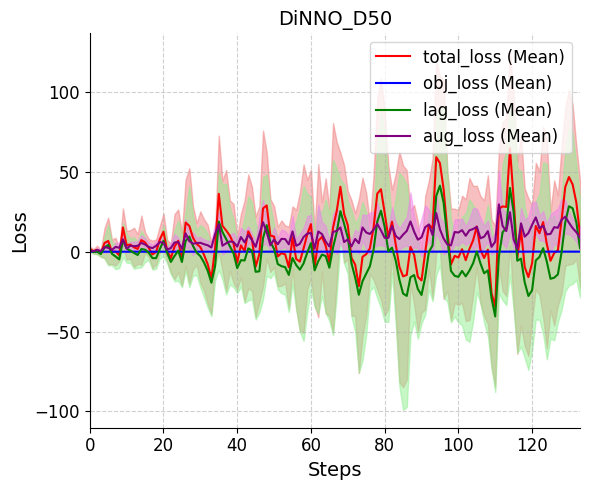

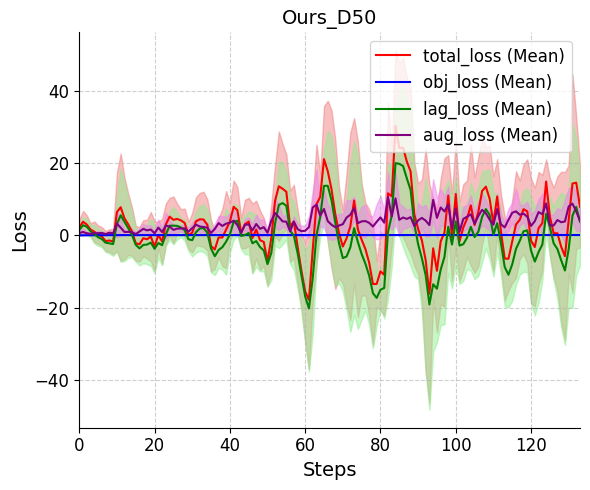

In [16]:


# Define colors and their lighter shades
colors = ['red', 'blue', 'green', 'purple']
light_colors = ['lightcoral', 'lightblue', 'lightgreen', 'violet']  # Lighter shades
loss_names = ['total_loss', 'obj_loss', 'lag_loss', 'aug_loss']
time = np.arange(total_loss_mean[0].shape[0])


for name in range(len(exp_name)):
    plt.figure(figsize=(6, 5))    # Plot each dataset
    for i, (mean, std, color, light_color) in enumerate(zip([total_loss_mean[name], obj_loss_mean[name], lag_loss_mean[name], aug_loss_mean[name]], [total_loss_std[name], obj_loss_std[name], lag_loss_std[name], aug_loss_std[name]], colors, light_colors)):
        plt.plot(time, mean, color=color, linestyle='-', label=f'{loss_names[i]} (Mean)')
        plt.fill_between(time, mean - std, mean + std, color=light_color, alpha=0.5)

    # Labels and title
    plt.xlabel('Steps', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12, loc='upper right')
    plt.title(f'{exp_name[name]}', fontsize=14)
    # Customize
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(min(time), max(time))
    #plt.ylim(-0.5, 0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
    # plt.savefig('three_datasets_plot.png', dpi=300)

# 3, Communication Analysis

In [1]:
def plot_edge_weights_over_time(G, node, edge_weight_history):
    """
    Plots the edge weights of a given node's neighbors over time as discrete points
    with subplots for each edge, integer x ticks, y ticks only at 0 and 1, and
    the percentage of times the weight was 1 in the title.

    Args:
      node: The node for which to plot edge weights.
      edge_weight_history: A dictionary containing the history of edge weights.
    """
    num_neighbors = len(G.adj[node])
    fig, axes = plt.subplots(num_neighbors, 1, figsize=(10, 2 * num_neighbors))
    if num_neighbors == 1:  # handle case of single neighbor
        axes = [axes]

    neighbor_index = 0
    for neighbor in G.neighbors(node):
        edge = (node, neighbor) if node < neighbor else (neighbor, node)
        weights = edge_weight_history[str(edge)]
        percent_one = sum(weights) / len(weights) * 100  # Calculate percentage of 1s
        ax = axes[neighbor_index]
        ax.plot(weights, 'o', label=f"Edge {edge}")
        ax.set_title(f"Edge {edge} Communication ({percent_one:.1f}%)", fontsize=18)

        ax.set_ylabel("Com On/Off", fontsize=18)
        ax.set_yticks([0, 1])

        # Only show x label and ticks for the last subplot
        if neighbor_index == num_neighbors - 1:
            ax.set_xlabel("Iteration", fontsize=14)
            num_iterations = len(weights)
            ax.set_xticks(range(0, num_iterations, max(1, num_iterations // 10)))
        else:
            ax.set_xticks([])  # Remove x ticks for other subplots

        ax.tick_params(axis='both', which='major', labelsize=18)  # Set tick label size
        neighbor_index += 1

    plt.tight_layout()
    plt.show()


In [4]:

agent_id = 0 
config_path = './configs/scannet/scene0106.yaml'
#config_path = './configs/ScanNet/scene0000.yaml'
edges_list = [[0, 1], [0, 2], [1, 2]]
#edges_list = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]

cfg = config.load_config(config_path)

# create graph 
G = nx.Graph()
num_agents = cfg['multi_agents']['num_agents']
G.add_nodes_from([i for i in range(num_agents)]) 
G.add_edges_from(edges_list, weight=1)

# Load the saved data from the JSON file
output_path = os.path.join(cfg['data']['output'], cfg['data']['exp_name'])

with open(os.path.join(output_path, 'graph_data.json'), 'r') as f:
    loaded_data = json.load(f)

edge_weight_history = loaded_data['edge_weight_history']

# Example usage: plot edge weights of node 1 over time
plot_edge_weights_over_time(G, agent_id, edge_weight_history)

FileNotFoundError: [Errno 2] No such file or directory: 'output/scannet/scene0106_00\\Ours_D50_3\\graph_data.json'

# 4, Visualizing a single mesh

Ctrl/Cmd + C : Copy current view status into the clipboard.  
Ctrl/Cmd + V : Paste view status from clipboard.  

# 5, Bar plots

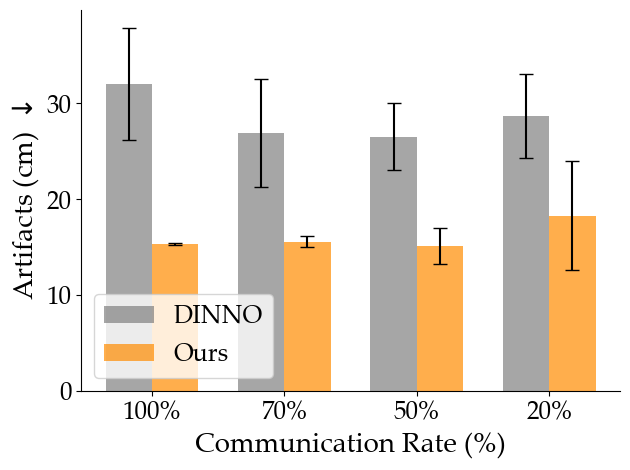

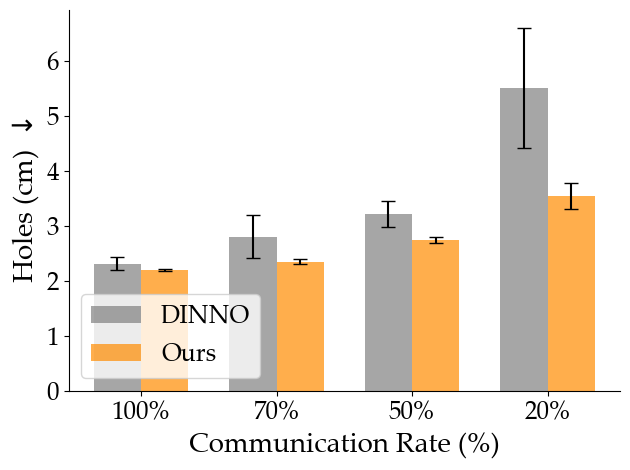

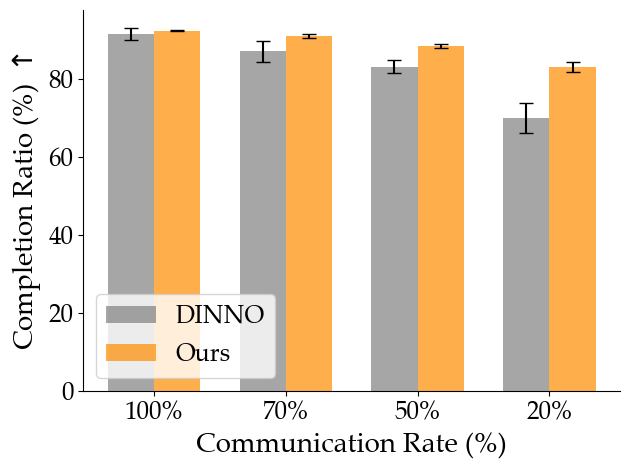

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the image
accuracy_data = {
    'DINNO': [[32.05, 5.82], [26.91, 5.64], [26.54, 3.49], [28.68, 4.41]],
    'Ours': [[15.35, 0.11], [15.57, 0.61], [15.13, 1.88], [18.30, 5.65]]
}

completion_data = {
    'DINNO': [[2.31, 0.12], [2.80, 0.39], [3.22, 0.24], [5.51, 1.09]],
    'Ours': [[2.20, 0.02], [2.35, 0.05], [2.74, 0.06], [3.55, 0.24]]
}

completion_ratio_data = {
    'DINNO': [[91.50, 1.56], [87.09, 2.61], [83.19, 1.74], [69.94, 3.78]],
    'Ours': [[92.35, 0.15], [91.05, 0.42], [88.48, 0.50], [83.12, 1.37]]
}

def create_bar_plot(data, title):
    # Set up the plot
    fig, ax = plt.subplots()
    plt.rcParams["font.family"] = "Palatino Linotype"



    # Create bars for each method
    for method, values in data.items():
        means = [value[0] for value in values]
        stds = [value[1] for value in values]
        x_pos = np.arange(len(means)) + 0.35 if method == 'Ours' else np.arange(len(means))

        # Set DINNO bars to gray
        color = 'gray' if method == 'DINNO' else 'darkorange' #if method == 'DINNO' else None
        ax.bar(x_pos, means, yerr=stds, label=method, width=0.35, alpha=0.7, capsize=5, color=color)  # Add color here


    # Set labels and title (font already Palatino due to plt.rcParams)
    ax.set_xlabel('Communication Rate (%)', fontsize=20)
    ax.set_ylabel(title, fontsize=20)
    ax.set_xticks(np.arange(len(means)) + 0.175)
    ax.set_xticklabels(['100%', '70%', '50%', '20%'])
    ax.tick_params(axis='both', which='major', labelsize=18)  # Set tick label size
    ax.legend(fontsize=18)  # Font already Palatino

    # Show the plot
    #plt.grid(True, axis='y', linestyle='--', alpha=1, c='k')  # If you want gridlines
    plt.legend(loc='lower left', fontsize=18) 
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()


# Create the bar plots
create_bar_plot(accuracy_data, r'Artifacts (cm) $ \downarrow$') 
create_bar_plot(completion_data, r'Holes (cm) $\downarrow$')
create_bar_plot(completion_ratio_data, r'Completion Ratio (%) $\uparrow$') 

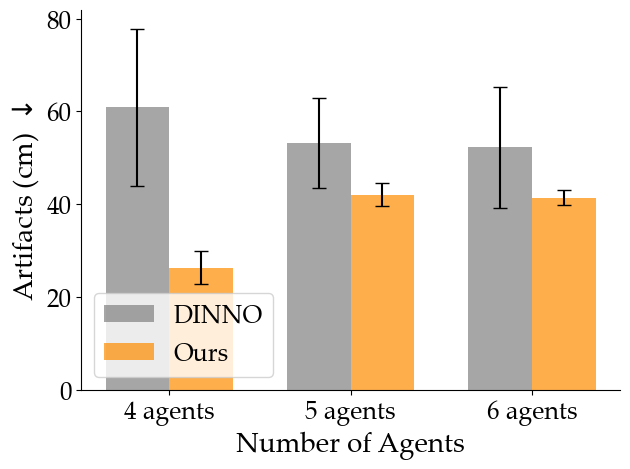

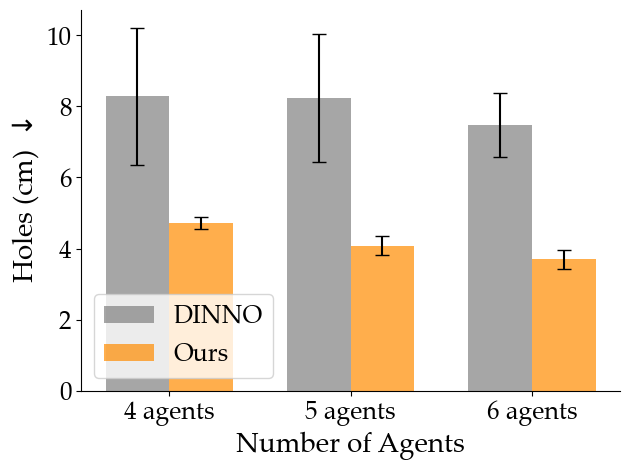

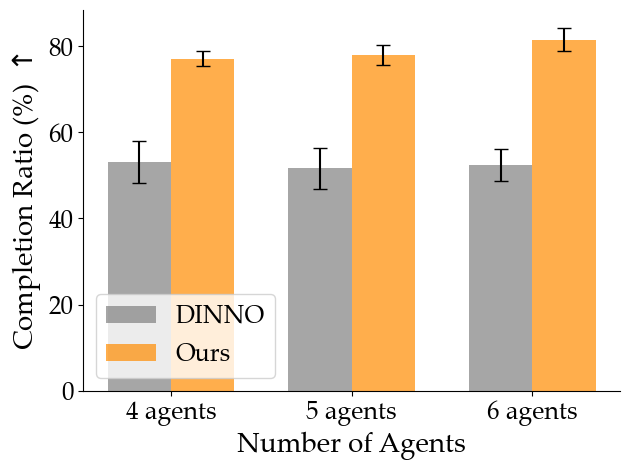

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the new image
accuracy_data = {
    'DINNO': [[60.88, 16.97], [53.19, 9.64], [52.22, 13.04]],
    'Ours': [[26.27, 3.58], [42.05, 2.40], [41.41, 1.67]]
}

completion_data = {
    'DINNO': [[8.28, 1.92], [8.23, 1.80], [7.47, 0.90]],
    'Ours': [[4.73, 0.17], [4.08, 0.27], [3.70, 0.27]]
}

completion_ratio_data = {
    'DINNO': [[53.15, 4.95], [51.66, 4.74], [52.43, 3.72]],
    'Ours': [[77.10, 1.72], [78.01, 2.38], [81.53, 2.67]]
}

# Function to create bar plots with standard deviation (same as the first version)
def create_bar_plot(data, title):
    fig, ax = plt.subplots()
    plt.rcParams["font.family"] = "Palatino Linotype"

    for method, values in data.items():
        means = [value[0] for value in values]
        stds = [value[1] for value in values]
        x_pos = np.arange(len(means)) + 0.35 if method == 'Ours' else np.arange(len(means))
        # Set DINNO bars to gray
        color = 'gray' if method == 'DINNO' else 'darkorange' #if method == 'DINNO' else None
        ax.bar(x_pos, means, yerr=stds, label=method, width=0.35, alpha=0.7, capsize=5, color=color)

    ax.set_xlabel('Number of Agents', fontsize=20)
    ax.set_ylabel(title, fontsize=20)
    ax.set_xticks(np.arange(len(means)) + 0.175)
    ax.set_xticklabels(['4 agents', '5 agents', '6 agents'])
    ax.tick_params(axis='both', which='major', labelsize=18)  # Set tick label size
    ax.legend()

    plt.tight_layout()
    #plt.grid(True, axis='y', linestyle='--', alpha=1, c='k')
    plt.legend(loc='lower left', fontsize=18) 
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

# Create the bar plots
create_bar_plot(accuracy_data, r'Artifacts (cm) $ \downarrow$') 
create_bar_plot(completion_data, r'Holes (cm) $\downarrow$')
create_bar_plot(completion_ratio_data, r'Completion Ratio (%) $\uparrow$') 